In [9]:
train_dir = '../dataset/train'

test_dir = '../dataset/test'

In [10]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_width = 224
img_height = 224
batch_size = 32

augmentation_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

normal_datagen = ImageDataGenerator(
    rescale=1./255
)

train_ds = augmentation_datagen.flow_from_directory(
    train_dir,
    subset='training',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

val_ds = augmentation_datagen.flow_from_directory(
    train_dir,
    subset='validation',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

test_ds = normal_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 8723 images belonging to 6 classes.
Found 2178 images belonging to 6 classes.
Found 2698 images belonging to 6 classes.


In [11]:
class_names = train_ds.class_indices
print(class_names)

{'freshapples': 0, 'freshbanana': 1, 'freshoranges': 2, 'rottenapples': 3, 'rottenbanana': 4, 'rottenoranges': 5}


In [12]:
from tensorflow.keras.applications import MobileNetV2

base_model = MobileNetV2(
    include_top=False, 
    weights='imagenet', 
    input_shape=(img_width, img_height, 3)
)

for layer in base_model.layers:
  layer.trainable = False

9406464/9406464 [==============================] - 2s 0us/step


In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(train_ds.num_classes, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 6)                 7

In [15]:
from tensorflow.keras.optimizers.legacy import Adam

model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [9]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True
)

In [16]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') >= 0.999):
      print("\nReached 99.9% accuracy. Stop Training")
      self.model.stop_training = True

callbacks = myCallback()

In [17]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=[callbacks]
)

Epoch 1/100
273/273 [==============================] - 107s 387ms/step - loss: 0.2047 - accuracy: 0.9285 - val_loss: 0.0561 - val_accuracy: 0.9793
Epoch 2/100
273/273 [==============================] - 99s 363ms/step - loss: 0.0708 - accuracy: 0.9756 - val_loss: 0.0293 - val_accuracy: 0.9913
Epoch 3/100
273/273 [==============================] - 100s 365ms/step - loss: 0.0498 - accuracy: 0.9822 - val_loss: 0.0207 - val_accuracy: 0.9936
Epoch 4/100
273/273 [==============================] - 101s 370ms/step - loss: 0.0314 - accuracy: 0.9892 - val_loss: 0.0157 - val_accuracy: 0.9949
Epoch 5/100
273/273 [==============================] - 104s 381ms/step - loss: 0.0370 - accuracy: 0.9858 - val_loss: 0.0176 - val_accuracy: 0.9927
Epoch 6/100
273/273 [==============================] - 101s 371ms/step - loss: 0.0298 - accuracy: 0.9897 - val_loss: 0.0121 - val_accuracy: 0.9968
Epoch 7/100
273/273 [==============================] - 101s 368ms/step - loss: 0.0241 - accuracy: 0.9916 - val_loss: 0.

273/273 [==============================] - 115s 420ms/step - loss: 0.0088 - accuracy: 0.9969 - val_loss: 0.0117 - val_accuracy: 0.9959
Epoch 57/100
273/273 [==============================] - 116s 425ms/step - loss: 0.0101 - accuracy: 0.9968 - val_loss: 2.7642e-04 - val_accuracy: 1.0000
Epoch 58/100
273/273 [==============================] - 114s 419ms/step - loss: 0.0067 - accuracy: 0.9975 - val_loss: 0.0050 - val_accuracy: 0.9986
Epoch 59/100
273/273 [==============================] - 115s 422ms/step - loss: 0.0060 - accuracy: 0.9983 - val_loss: 0.0011 - val_accuracy: 0.9995
Epoch 60/100
273/273 [==============================] - 115s 420ms/step - loss: 0.0055 - accuracy: 0.9979 - val_loss: 0.0102 - val_accuracy: 0.9954
Epoch 61/100
273/273 [==============================] - 117s 427ms/step - loss: 0.0119 - accuracy: 0.9967 - val_loss: 0.0078 - val_accuracy: 0.9977
Epoch 62/100
273/273 [==============================] - 115s 422ms/step - loss: 0.0071 - accuracy: 0.9981 - val_loss: 2.2

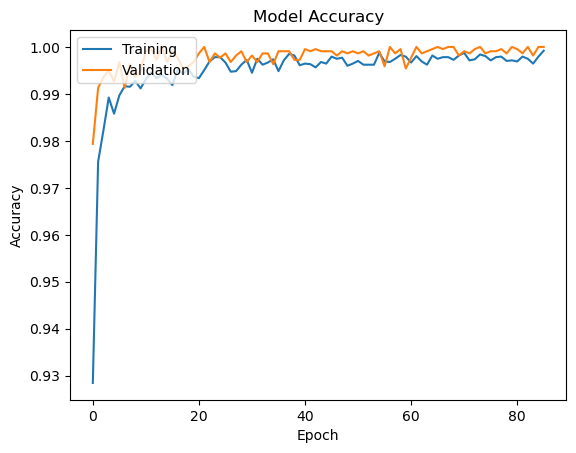

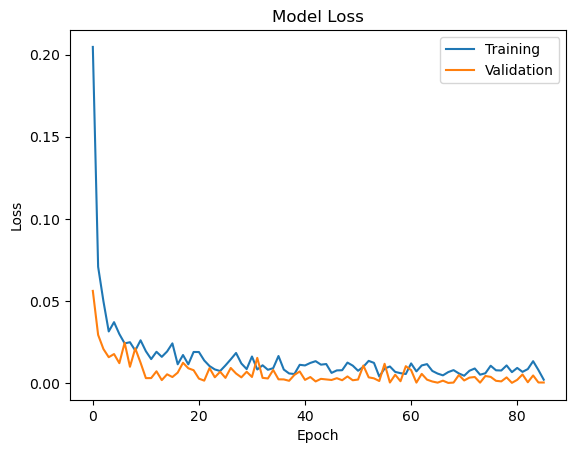

In [18]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [19]:
scores = model.evaluate(test_ds)

print('Akurasi: %.2f%%' % (scores[1] * 100))

85/85 [==============================] - 17s 197ms/step - loss: 0.0135 - accuracy: 0.9963
Akurasi: 99.63%


In [20]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

y_pred = np.argmax(model.predict(test_ds), axis=1)
y_true = test_ds.classes

cm = confusion_matrix(y_true, y_pred)
cr = classification_report(y_true, y_pred, target_names=test_ds.class_indices.keys())

85/85 [==============================] - 17s 197ms/step


In [21]:
print(cm)

[[395   0   0   0   0   0]
 [  0 381   0   0   0   0]
 [  0   0 386   0   0   2]
 [  4   0   0 596   0   1]
 [  0   0   0   0 530   0]
 [  0   0   1   2   0 400]]


In [22]:
print(cr)

               precision    recall  f1-score   support

  freshapples       0.99      1.00      0.99       395
  freshbanana       1.00      1.00      1.00       381
 freshoranges       1.00      0.99      1.00       388
 rottenapples       1.00      0.99      0.99       601
 rottenbanana       1.00      1.00      1.00       530
rottenoranges       0.99      0.99      0.99       403

     accuracy                           1.00      2698
    macro avg       1.00      1.00      1.00      2698
 weighted avg       1.00      1.00      1.00      2698



In [25]:
saved_model = "model_frutify.h5"
model.save(saved_model)

INFO:tensorflow:Assets written to: model_frutify/assets


INFO:tensorflow:Assets written to: model_frutify/assets


In [31]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

reconstructed_model = keras.models.load_model("model_frutify")

# Let's check:
np.testing.assert_allclose(
    model.predict(test_ds), reconstructed_model.predict(test_ds)
)

# The reconstructed model is already compiled and has retained the optimizer
# state, so training can resume:
reconstructed_model.fit(test_ds)

85/85 [==============================] - 18s 198ms/step - loss: 0.0277 - accuracy: 0.9948
